We will approach this with agglomerative clustering to visualize cluster formation and merging.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [13]:
data = pd.read_csv("Online_Retail.csv")
print("Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nInfo:\n")
data.info()

Shape: (541909, 8)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [14]:
#scout for missing 
print("NAs: \n", data.isnull().sum())

NAs: 
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [15]:
#get a sample to view what data seems to be necessary and not
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [16]:
#we need to focus only on the rows that matter
data = data[data['CustomerID'].notnull() & data['Description'].notnull()]

# Remove non-positive quantities and unit prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

#make total price 
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

#convert invoice date to fate time
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


#drop both invoince no, customer id, description
data = data.drop(columns=['InvoiceNo', 'Description', 'StockCode'])

In [17]:
print(data.head())

   Quantity         InvoiceDate  UnitPrice  CustomerID         Country  \
0         6 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   
1         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
2         8 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   
3         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   
4         6 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   

   TotalPrice  
0       15.30  
1       20.34  
2       22.00  
3       20.34  
4       20.34  


In [21]:
#its evident there are a lot of entries per customer so we can group them by that
latest_date = data['InvoiceDate'].max()

#make an RFM table (recency, Frequency, monetary)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, 
    'InvoiceDate': 'count',
    'TotalPrice': 'sum',
    'Country': 'first'  # Keep 1st country per customer
}).rename(columns={
    'InvoiceDate': 'Frequency',  # overwrites lambda's result
    'TotalPrice': 'Monetary',
    'Country': 'Country'
})


In [22]:
#recompute recency
recency = data.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (latest_date - x).days)
rfm['Recency'] = recency
print("RFM Table\n")
print(rfm.head())


RFM Table

            Frequency  Monetary         Country  Recency
CustomerID                                              
12346.0             1  77183.60  United Kingdom      325
12347.0           182   4310.00         Iceland        1
12348.0            31   1797.24         Finland       74
12349.0            73   1757.55           Italy       18
12350.0            17    334.40          Norway      309


In [23]:
#encode this and scale everything
rfm_encoded = pd.get_dummies(rfm, columns=["Country"],drop_first=True)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_encoded)

#keep a coup of scaled feature names to track them
feature_names = rfm_encoded.columns.tolist()

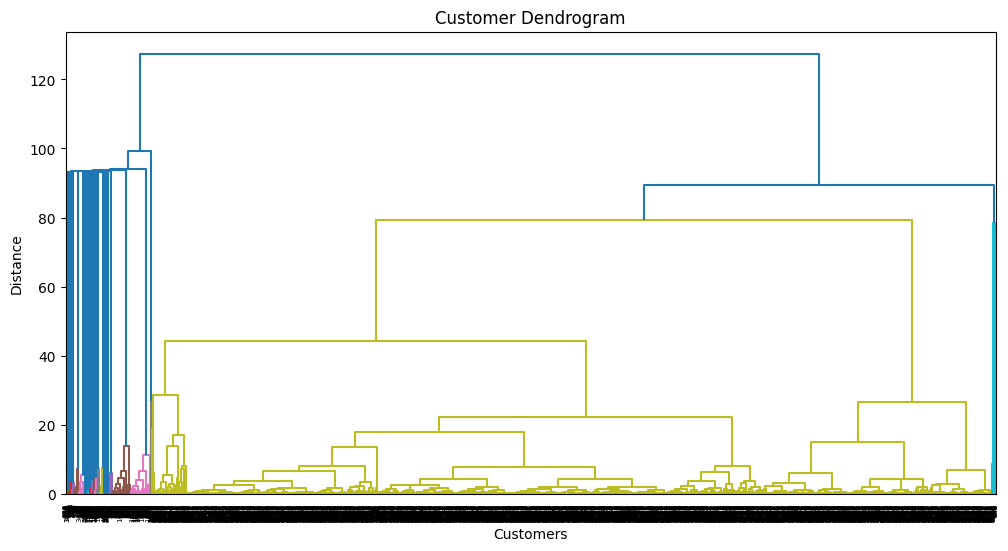

In [24]:
#dendogram and agglomerative clustering phase

#plot a dendogram to see number fo clusters
linked = linkage(rfm_scaled, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
plt.title("Customer Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Distance")
plt.show()

In [26]:
#perform agg clustering
#roughly four main clusters
agg = AgglomerativeClustering(n_clusters = 4)
rfm['Cluster'] = agg.fit_predict(rfm_scaled)

In [27]:
#profile segments
profile = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
profile['Count'] = rfm['Cluster'].value_counts().sort_index()
print(profile)

            Recency    Frequency      Monetary  Count
Cluster                                              
0        100.171617    78.132013   2254.935710    303
1         91.253682    90.892331   1963.877436   3938
2         56.666667  2412.000000  88515.300000      3
3         76.659574    96.170213   2434.756809     94


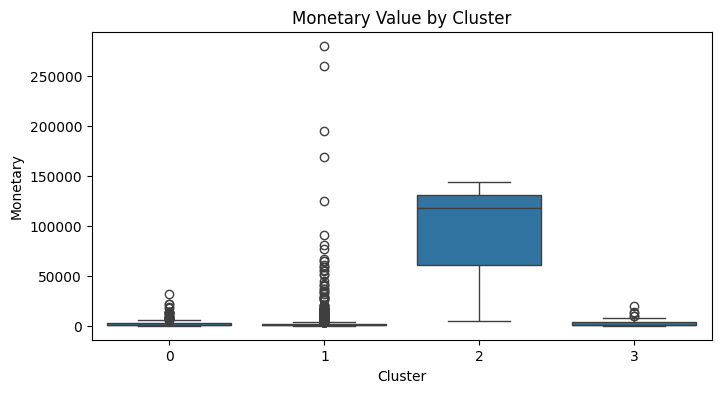

In [28]:
#Visualize:
plt.figure(figsize=(8, 4))
sns.boxplot(data=rfm, x='Cluster', y='Monetary')
plt.title("Monetary Value by Cluster")
plt.show()